In [197]:
import numpy as np
% tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import time

In [218]:
#load the dataset
(training_images, training_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

Training_images shape:  (60000, 28, 28)
How many test samples are there:  10000
Training labels shape:  (60000,)
One label example:  9


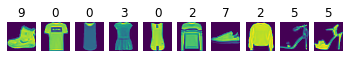

In [199]:
#Visualization
print("Training_images shape: ", training_images.shape)
print("How many test samples are there: ", test_images.shape[0])
print("Training labels shape: ", training_labels.shape)
print("One label example: ", training_labels[0])

#Visualize the images
fig, ax = plt.subplots(1,10)

for i in range(10):
  ax[i].imshow(training_images[i])
  ax[i].set_title(training_labels[i])
  ax[i].axis("off")




## Preprocessing

In [219]:
#perform necessary preprocessing steps
#for our autoencoder we do not need the labels

#normalizing the images
training_images = tf.data.Dataset.from_tensor_slices(training_images)
training_images = training_images.map(lambda img : tf.cast(tf.expand_dims(img,-1), tf.float32))
training_images = training_images.map(lambda img: img/255)

#Prepare the dataset
#this includes dividing the dataset into batches
training_data = training_images
training_data = training_data.batch(64)
training_data = training_data.shuffle(buffer_size= 64)
training_data = training_data.prefetch(16)


test_images = test_images[1000:]
test_images_tsne = test_images[:1000]
test_images = tf.data.Dataset.from_tensor_slices(test_images)
test_images = test_images.map(lambda img : tf.cast(tf.expand_dims(img,-1), tf.float32))
test_images = test_images.map(lambda img: img/255)

test_data = test_images
test_data = test_data.batch(20)
test_data = test_data.shuffle(buffer_size= 20)
test_data = test_data.prefetch(10)


test_images_tsne = tf.data.Dataset.from_tensor_slices(test_images_tsne)
test_images_tsne = test_images_tsne.map(lambda img : tf.cast(tf.expand_dims(img,-1), tf.float32))
test_images_tsne = test_images_tsne.map(lambda img: img/255)
test_images_tsne = test_images_tsne.batch(20).prefetch(10)

test_labels = test_labels[:1000]

## 1. Convolutional Autoencoder

### 1.1. Encoder

In [201]:
class EncBlock(tf.keras.layers.Layer):
  def __init__(self, number_filters):
    super(EncBlock, self).__init__()
    self.conv = tf.keras.layers.Conv2D(filters = number_filters, activation = None, kernel_size = 3, padding = 'same')
    self.batch_norm = tf.keras.layers.BatchNormalization()
    self.relu = tf.keras.layers.ReLU()
    self.pool = tf.keras.layers.MaxPool2D(strides = (2,2))

  def call(self, input_x, training):
    x = self.conv(input_x)
    x = self.batch_norm(x, training)
    x = self.relu(x)
    x = self.pool(x)

    return x

class Encoder(tf.keras.Model):
  def __init__(self):
    super(Encoder, self).__init__()
    #self.dense_layer = tf.keras.layers.Dense(units = (28*28), activation = tf.keras.activations.relu)
    self.block1 = EncBlock(32)
    self.block2 = EncBlock(16)

    self.flatten = tf.keras.layers.Flatten()
    self.encoding_layer = tf.keras.layers.Dense(units = 10, activation = tf.keras.activations.softmax)

  def call(self, input_x, training):

    x = self.block1(input_x, training)
    x = self.block2(x, training)
    x = self.flatten(x)
    x = self.encoding_layer(x)

    return x


### 1.2. Decoder

In [202]:
class Decoder(tf.keras.Model):
  def __init__(self):
    super(Decoder, self).__init__()
    #firstly restore dimensionality with a dense_layer
    
    self.dense_layer = tf.keras.layers.Dense(units = (7*7*32), activation = tf.keras.activations.relu)
    self.reshape = tf.keras.layers.Reshape((7,7,32))
    self.ConvT_1 = tf.keras.layers.Conv2DTranspose(filters =16, padding = 'same', kernel_size = 3, strides = (2,2))
    self.batch_norm1 = tf.keras.layers.BatchNormalization()
    self.relu1 = tf.keras.layers.ReLU()
    self.ConvT_2 = tf.keras.layers.Conv2DTranspose(filters =16, padding = 'same', kernel_size = 3, strides = (2,2))
    self.batch_norm2 = tf.keras.layers.BatchNormalization()
    self.relu2 = tf.keras.layers.ReLU()
    self.output_layer = tf.keras.layers.Conv2D(filters=1, padding = 'same', kernel_size = 3, activation= tf.keras.activations.sigmoid)

  def call(self, input_x, training):
    x = self.dense_layer(input_x)
    x = self.reshape(x)
    x = self.ConvT_1(x)
    x = self.batch_norm1(x, training)
    x = self.relu1(x)
    x = self.ConvT_2(x)
    x = self.batch_norm2(x, training)
    x = self.relu2(x)
    x = self.output_layer(x)

    return x

### 1.3. Autoencoder

In [203]:
class ConvoAE(tf.keras.Model):
  def __init__(self):
    super(ConvoAE, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
    
  def call(self, input_x, training):
    x = self.encoder(input_x, training)
    x = self.decoder(x, training)

    return x

2. Variational Autoencoder

## Training

In [204]:
def train_step(model, samples, loss_function, optimizer, training= True):
  with tf.GradientTape() as tape:
    reconstructed_img = model(samples, training)
    loss = loss_function(reconstructed_img, samples)
    
    gradients = tape.gradient(loss, model.trainable_variables)
  
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  return loss

def test(model, input, loss_function, training= False):
  losses = []
  accuracies = []

  for image in input:
    reconstructed_img = model(image, training)
    loss = loss_function(reconstructed_img, image)

  return loss

def plot_img(input_images, model):
  
  for image in input_images:
    image = np.reshape(image[0].numpy(),(1,28,28,1))
    image_rec = model(image, False)

    fig, ax = plt.subplots(1,2)
    ax[0].imshow(tf.squeeze(image_rec))
    ax[0].set_title("reconstructed image")
    ax[0].axis("off")
    ax[1].imshow(tf.squeeze(image))
    ax[1].set_title("input")
    ax[1].axis("off")

    plt.show()


In [205]:
def timing(start):
    now = time.time()
    time_per_training_step = now - start
    # compute duration of an epoch
    return round(time_per_training_step, 2)

0 . epoch --------------------------------------------------------------------------------


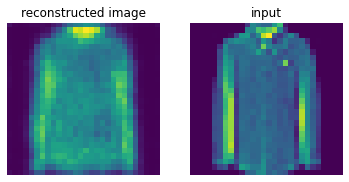

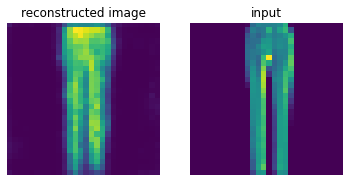

the training step and test evaluation took 21.31 seconds
train_loss 0.020032205
test_loss 0.025845684
1 . epoch --------------------------------------------------------------------------------


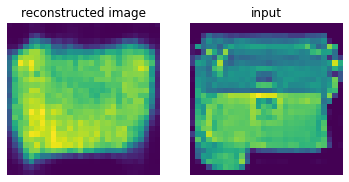

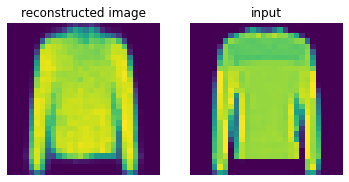

the training step and test evaluation took 21.32 seconds
train_loss 0.017947186
test_loss 0.020577207
2 . epoch --------------------------------------------------------------------------------


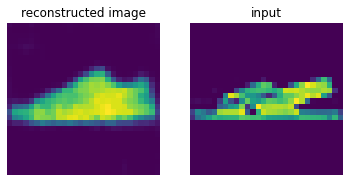

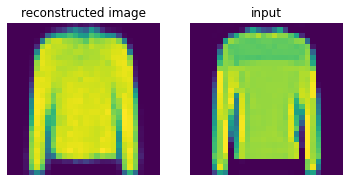

the training step and test evaluation took 21.44 seconds
train_loss 0.01722149
test_loss 0.019188398
3 . epoch --------------------------------------------------------------------------------


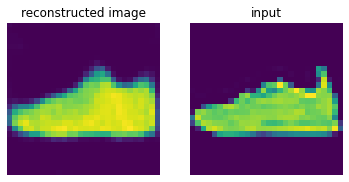

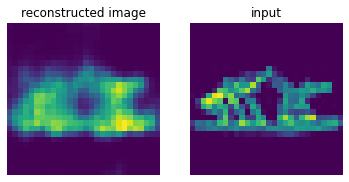

the training step and test evaluation took 21.59 seconds
train_loss 0.016433397
test_loss 0.01674432
4 . epoch --------------------------------------------------------------------------------


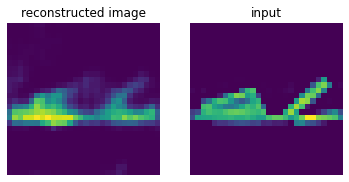

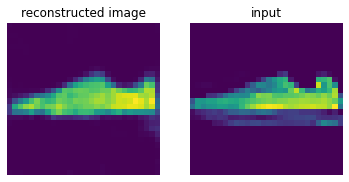

the training step and test evaluation took 21.46 seconds
train_loss 0.016222779
test_loss 0.01563237
5 . epoch --------------------------------------------------------------------------------


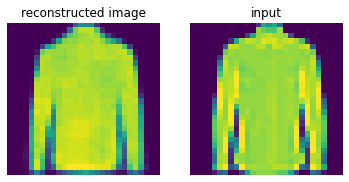

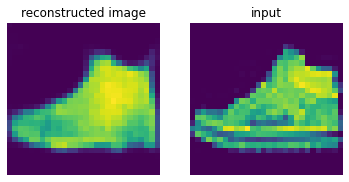

the training step and test evaluation took 21.59 seconds
train_loss 0.015753351
test_loss 0.017055223
6 . epoch --------------------------------------------------------------------------------


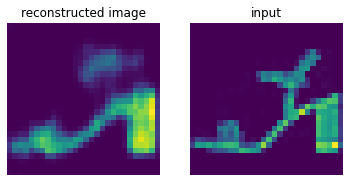

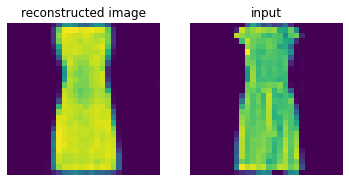

the training step and test evaluation took 21.49 seconds
train_loss 0.015548734
test_loss 0.015168626
7 . epoch --------------------------------------------------------------------------------


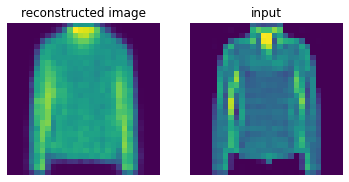

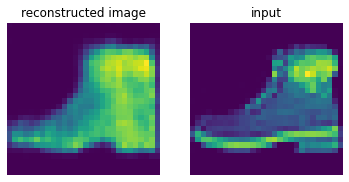

the training step and test evaluation took 21.4 seconds
train_loss 0.0149888415
test_loss 0.015726056
8 . epoch --------------------------------------------------------------------------------


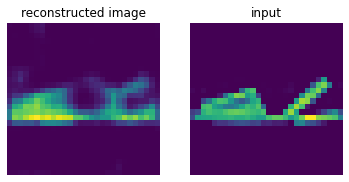

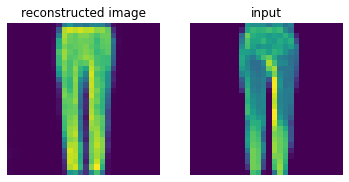

the training step and test evaluation took 21.42 seconds
train_loss 0.015164243
test_loss 0.016524775
9 . epoch --------------------------------------------------------------------------------


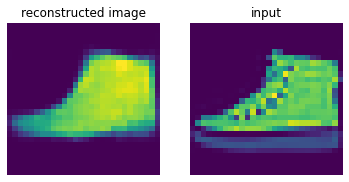

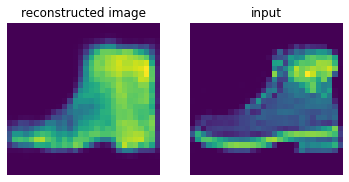

the training step and test evaluation took 21.5 seconds
train_loss 0.015116584
test_loss 0.01465673


In [206]:
tf.keras.backend.clear_session()

conv_ae = ConvoAE()

#Define hyperparameters
#How many training epochs do we perform
epochs = 10
#define the learning rate which influences the magnitude with which we update the models parameters
learning_rate = 0.001

loss_function = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate)

running_average_factor = 0.95


steps = []

for epoch in range(epochs):
  print(epoch, ". epoch --------------------------------------------------------------------------------")
  steps.append(epoch)
  train_losses = []
  test_losses = []

  start = time.time()
  original_loss = 0
  for images in training_data:
    train_loss = train_step(conv_ae, images, loss_function, optimizer, training = True)
    
    original_loss = running_average_factor * original_loss + (1-running_average_factor) * train_loss
  train_losses.append(original_loss)
  test_loss = test(conv_ae,test_data, loss_function)
  test_losses.append(test_loss)

  plot_img(training_data.take(2),conv_ae)

  print(f"the training step and test evaluation took {timing(start)} seconds")
  #some sort of plotting
  print("train_loss", np.mean(train_losses))
  print("test_loss", test_loss.numpy())

## Latent Space Analysis

In [220]:
#TSNE stuff
from sklearn.manifold import TSNE

label_dict = {0: "tab:blue",1: "tab:green", 2: "tab:orange", 3: "tab:red", 4: "tab:purple",
               5: "tab:brown", 6: "tab:pink", 7: "tab:grey", 8: "tab:olive", 9: "tab:cyan"}

plot_labels = ["top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "boot"]
embeddings = []

#walk through the test_data and produce embeddings
#athe data is batched
for image in test_images_tsne:
  embeddings.append(conv_ae.encoder(image))

embeddings_arr = np.array(embeddings)
embeddings_arr = np.reshape(embeddings_arr, (1000,10))

embeddings_arr = TSNE(n_components=2).fit_transform(embeddings_arr)
embedded_x = embeddings_arr[:,0]
embedded_y = embeddings_arr[:,1]
embedded_label = test_labels




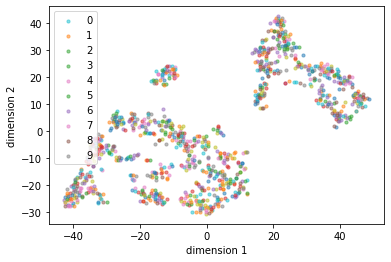

In [221]:
#Visualization
import matplotlib.colors as mcolors
fig, ax = plt.subplots()

for x, y, group in zip(embedded_x, embedded_y, embedded_label):
  ax.scatter(x, y, c = label_dict[group], alpha = 0.5, s = 10)

plt.xlabel("dimension 1")
plt.ylabel("dimension 2")
plt.legend(label_dict)
plt.show()

In [ ]:
plt.scatter(embedded_x, embedded_y, c = embedded_label, s = 0.8)

Side note:
Thisweek noone of us was able to drop by in the Q and A sessions, therefore our homework might not be done in the way you expected. We tried our best to produce a result that fits your task description which we were somtimes unsure about.